In [178]:
# load package
# string 
import re

# math
import pandas as pd
import numpy as np
import scipy as sp
import random

# sys
import sys
import os
import time
import warnings

# nlp
from pattern.de import parse, conjugate, singularize, pluralize

# machine learning
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, gaussian_process, discriminant_analysis
from xgboost import XGBClassifier

# model utils
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection 
from sklearn import model_selection
from sklearn import metrics

# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix #??
# = show plots in Jupyter Notebook browser
%matplotlib inline 
mpl.style.use('ggplot') #??
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8 #??

# show all columns
from IPython.display import display
pd.options.display.max_columns = None

# memory manage
import gc

# other
import tqdm as tqdm

# self define
sys.path.append('../../utils/')

In [179]:
# read files
lb_wsp_2014 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2014.csv', sep = ';')
lb_wsp_2015 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2015.csv', sep = ';')
lb_wsp_2016 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2016.csv', sep = ';')
lb_wsp_2017 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2017.csv', sep = ';')
lb_wsp_2018 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2018.csv', sep = ';')
std_wsp_2014 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2014.csv', sep = ';')
std_wsp_2015 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2015.csv', sep = ';')
std_wsp_2016 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2016.csv', sep = ';')
std_wsp_2017 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2017.csv', sep = ';')
std_wsp_2018 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2018.csv', sep = ';')
# cat
d1 = lb_wsp_2014.copy()
d2 = lb_wsp_2015.copy()
d3 = lb_wsp_2016.copy()
d4 = lb_wsp_2017.copy()
d5 = lb_wsp_2018.copy()

d6 = std_wsp_2014.copy()
d7 = std_wsp_2015.copy()
d8 = std_wsp_2016.copy()
d9 = std_wsp_2017.copy()
d10 = std_wsp_2018.copy()

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [183]:
# for training we use data from 14 - 17 in lb_wsp
train1 = pd.concat([d1,d2,d3,d4,d5], 0)
train2 = pd.concat([d6,d7,d8,d9,d10], 0)
train1['Autohaus'] = 'leonberg'
train2['Autohaus'] = 'weil'
#train = pd.concat([train1, train2], 0)
train = train1.copy()

In [4]:
del d1,d2,d3,d4,d5, d6,d7,d8,d9,d10, train1, train2
gc.collect()

25

In [5]:
# 转化为auftrag table， 但是这次合并的是Teile-Nr项
# 给的数据的每一行都是一个维修项，初衷是，把属于同一个auftrag的维修项合并到一起，看一下，在同一个Auftrag中，经常一起修的是那些内容

def toAuftragTable(df, att, auftn, clean = True):
    """
    input:
        df, DataFrame:
            the dataframe
        att, string:
            the column name of the target attribute
        auftn, string:
            the column name of the aftragsnummer attribute
        clean:
            when true, drop the null item in auftn attribute.
    output:
        df_g, DataFrame:
            dataframe contrains two columns auftn and att
            type of item in att is string, separate with ';'
    """
    # assert: make sure the type of the attributes inputted
    
    # extract the att and date columns
    df = df[[att, auftn]]
    # set type to object
    #df[att] = df[att].astype('object')
    #df[auftn] = df[auftn].astype('object')
    # if clean is True, drop the fake data, like the null data
    if clean:
        print("Falls Null date exist, drop these dates directly")
        #df = df.drop(df[df[att].isnull()].index)
        df = df.drop(df[df[auftn].isnull()].index)
    # group and sum 
    df_g = df.groupby([auftn], as_index = False).apply(agg)
    return df_g

# apply 只能对单行进行处理，而不是对整个分组进行处理，所以估计应该把axis换成1，比较好
def agg(x):
    # 是否用‘ ’分隔会比较好，这样就不用对初始的属性，
    # x 在这里是dataframe？？？
    #x = [str(i) for i in x]
    x = x.apply(lambda x: ';'.join(set([str(i) for i in x])), axis = 0)
    #x = x.apply(lambda x: ' '.join(set(x)), axis = 0)
    #print(x.columns.values)
    return x

In [6]:
df = toAuftragTable(train, 'Teile-Nr', 'Auftragsnummer')

Falls Null date exist, drop these dates directly


In [7]:
df = df.copy()

In [8]:
# remove wierd auftragsnummer
df = df.drop(df[df['Auftragsnummer'] == '103K'].index)
df = df.drop(df[df['Auftragsnummer'] == '77KW'].index)
df = df.drop(df[df['Auftragsnummer'] == '110KW 2.0 '].index)
df = df.drop(df[df['Auftragsnummer'] == '75KW'].index)

In [9]:
# merget the data original dataframe to df
df_sel = train[['Auftragsnummer', 'KM-Stand', 'Auftragsdatum', 'Markencode', 'Lagerortcode', 'Adressanredecode', 'Fahrgestellnummer', 'Motorcode', 'Modell', 'Getriebecode']]
df_sel = df_sel.drop_duplicates()
df = pd.merge(df, df_sel, how = 'left', on = 'Auftragsnummer')

In [10]:
del train
gc.collect()

138

## calcutelate the frequent of each Fahrgestellnummer

- 可以很成一个方法，就是专门用来看频率的

In [85]:
df['year'] = df['Auftragsdatum'].map(lambda x: x[6:])

In [86]:
df['year'].unique()

array(['2018', '2014', '2013', '2015', '2016', '2017', '1753'], dtype=object)

In [87]:
df_14 = df.loc[df['year'] == '2014', ]
df_15 = df.loc[df['year'] == '2015', ]
df_16 = df.loc[df['year'] == '2016', ]
df_17 = df.loc[df['year'] == '2017', ]
df_18 = df.loc[df['year'] == '2018', ]

In [88]:
# get the count of Fahrgestellnummer for year 2014
def get_count_for_Fahrgestellnummer(df, name = '2014'):
    tmp = df[['Fahrgestellnummer']]
    tmp['count'] = 1
    tmp = tmp.groupby('Fahrgestellnummer', as_index = False).count()
    fi = sns.countplot('count', data = tmp)
    fi.set_xlabel('frequent in '+str(name))
    return tmp

In [135]:
def get_count_for_frequent(df, year = 2014, top = 5):
    tmp = df[['Fahrgestellnummer']]
    tmp['frequent'] = 1
    tmp = tmp.groupby('Fahrgestellnummer', as_index = False).count()
    tmp = tmp[['frequent']]
    tmp['count'] = 1
    tmp = tmp.groupby('frequent', as_index = False).count()
    #plt.plot(tmp)
    tmp['year'] = year
    rest = pd.DataFrame({'frequent':['>5'], 'count':[tmp[tmp['frequent']> top]['count'].sum()], 'year':[year]})
    tmp = tmp[tmp['frequent']<= top].append(rest)
    tmp['count'] = tmp['count']/tmp['count'].sum()
    return tmp

In [136]:
t_14 = get_count_for_frequent(df_14)
t_15 = get_count_for_frequent(df_15, 2015)
t_16 = get_count_for_frequent(df_16, 2016)
t_17 = get_count_for_frequent(df_17, 2017)
t_18 = get_count_for_frequent(df_18, 2018)
tmp = pd.concat([t_14,t_15,t_16,t_17,t_18], 0)
del t_14, t_15, t_16, t_17, t_18
gc.collect

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<function gc.collect>

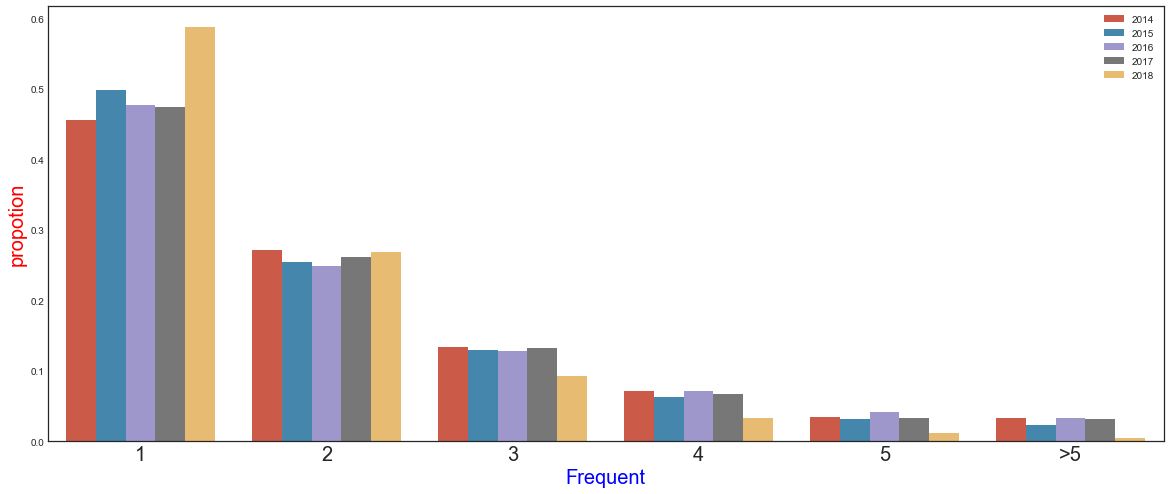

In [138]:
f, ax = plt.subplots(figsize = (20, 8))
sns.barplot(x = 'frequent', y='count',hue='year', data=tmp)
ax.set_ylabel('propotion', fontsize=20, color='r')
ax.set_xlabel('Frequent', fontsize=20, color='b')
#ax.set_yticklabels(ax.get_yticklabels(), fontsize = 20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 20)
#ax.set_title('Leonberg', fontsize=22, position=(0.5,1.05))
plt.legend(loc = "upper right")

In [130]:
tmp

,count,frequent,year
0,4647,1,2014
1,2765,2,2014
2,1368,3,2014
3,721,4,2014
4,355,5,2014
0,337,>5,2014
0,5027,1,2015
1,2565,2,2015
2,1303,3,2015
3,631,4,2015


In [103]:
pd.DataFrame({'frequent':['>5'], 'count':[33], 'year':[2013]})

,count,frequent,year
0,33,>5,2013


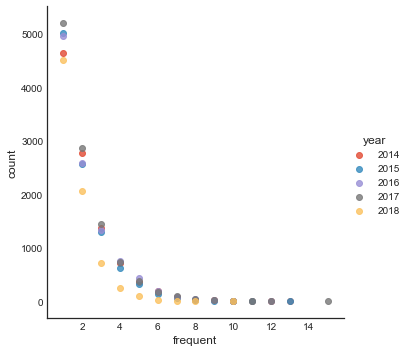

In [30]:
sns.lmplot(x = 'frequent', y='count',hue='year', data=tmp,fit_reg = False)

In [18]:
del tmp
gc.collect()

26

## 把每年出现次数大于一定阈值的顾客称为回头客，分析回头客和非回头客维修方向有什么不同

In [11]:
#TODO
def get_frequent_customer(df, th = 5):
    tmp = df[['Fahrgestellnummer']]
    tmp['count'] = 1
    tmp = tmp.groupby('Fahrgestellnummer', as_index = False).count()
    tmp['is_frequent'] = tmp['count'] > th
    tmp = pd.merge(df, tmp, on = 'Fahrgestellnummer', how = 'left')
    return tmp

In [14]:
tmp = get_frequent_customer(df, 12)

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [43]:
tmp['is_frequent'].value_counts()

False    80394
True     17119
Name: is_frequent, dtype: int64

In [16]:
tmp = tmp.drop(tmp[tmp['is_frequent'].isna()].index, axis=0)

In [44]:
fre = tmp[tmp['is_frequent']]
nf = tmp[tmp['is_frequent'].map(lambda x: not x)].sample(n = 17119)

In [45]:
fre['Teile-Nr'].to_csv('/tmp/tmp.csv', sep = ';', index = False)
dic1 = FreDict('/tmp/tmp.csv', header = True, sep = ';', clean = True, recover = True, singular = False)

In [46]:
nf['Teile-Nr'].to_csv('/tmp/tmp.csv', sep = ';', index = False)
dic2 = FreDict('/tmp/tmp.csv', header = True, sep = ';', clean = True, recover = True, singular = False)

In [47]:
A = [i[0] for i in dic1.top(20)]
B = [i[0] for i in dic2.top(20)]
C = set(A + B)
dis = len(C)/(len(A) + len(B) - len(C))
dis

1.6666666666666667

In [12]:
def get_distance(df, th = 10):
    tmp = get_frequent_customer(df, th)
    tmp = tmp.drop(tmp[tmp['is_frequent'].isna()].index, axis=0)
    fre = tmp[tmp['is_frequent']]
    nf = tmp[tmp['is_frequent'].map(lambda x: not x)]
    fre['Teile-Nr'].to_csv('/tmp/tmp.csv', sep = ';', index = False)
    dic1 = FreDict('/tmp/tmp.csv', header = True, sep = ';', clean = True, recover = True, singular = False)
    nf['Teile-Nr'].to_csv('/tmp/tmp.csv', sep = ';', index = False)
    dic2 = FreDict('/tmp/tmp.csv', header = True, sep = ';', clean = True, recover = True, singular = False)
    A = [i[0] for i in dic1.top(20)]
    B = [i[0] for i in dic2.top(20)]
    C = set(A + B)
    dis = len(C)/(len(A) + len(B) - len(C))
    print('############')
    print('th = ' +str(th) +' => dis = ' + str(dis))
    print('len(A):' + str(len(A)))
    print('len(B):' + str(len(B)))
    print('len(C):' + str(len(C)))
    print('A', A)
    print('B', B)
    del tmp, fre, nf, dic1, dic2
    gc.collect()
    return dis

In [ ]:
#for i in range(1,20):
#    get_distance(df, i)

In [164]:
get_distance(df,1)

############
th = 1 => dis = 1.5
len(A):20
len(B):20
A ['nan', '90813202', 'SKN', '000DS', '052164DS', 'OEL02', 'WHT000729A', 'ZZ', '10648301', 'W-AG-EM', '000010006', '03L115562', '1K1819653B', '0138157', 'GRU', '9B9', 'SKBV18', '1100', '03N115562', '2000']
B ['nan', '90813202', 'SKN', '000DS', '052164DS', '000010006', 'ZZ', 'GRU', '9B9', 'OEL02', 'WHT000729A', '1K1819653B', '10648301', '013DS', '0138157', '03L115562', 'W-LRA', '1100', 'LMW030000Z0', '03C']


1.5

In [16]:
get_distance(df,2)

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


############
th = 2 => dis = 1.2222222222222223
len(A):20
len(B):20
len(C):22
A ['nan', '90813202', 'SKN', '052164DS', '000DS', 'OEL02', 'WHT000729A', '10648301', 'W-AG-EM', 'ZZ', '03L115562', '000010006', '1K1819653B', '0138157', 'GRU', '9B9', 'SKBV18', '1100', '03N115562', '2000']
B ['nan', '90813202', 'SKN', '000DS', '000010006', '052164DS', 'ZZ', '9B9', 'OEL02', 'WHT000729A', 'GRU', '1K1819653B', '10648301', '03L115562', '0138157', '013DS', '1100', 'W-LRA', 'W-AG-EM', 'SKBV18']


1.2222222222222223

In [17]:
get_distance(df,3)

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


############
th = 3 => dis = 1.105263157894737
len(A):20
len(B):20
len(C):21
A ['nan', '90813202', 'SKN', '052164DS', '000DS', 'OEL02', 'WHT000729A', 'W-AG-EM', '10648301', 'ZZ', '03L115562', '000010006', '1K1819653B', '0138157', 'GRU', '9B9', 'SKBV18', '1100', '2000', '03N115562']
B ['nan', '90813202', 'SKN', '000DS', '052164DS', '000010006', 'ZZ', 'WHT000729A', 'OEL02', '9B9', 'GRU', '1K1819653B', '10648301', '03L115562', '0138157', '1100', '013DS', 'W-AG-EM', 'SKBV18', '03N115562']


1.105263157894737

In [14]:
get_distance(df,4)

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


############
th = 4 => dis = 1.2222222222222223
len(A):20
len(B):20
len(C):22
A ['nan', 'SKN', '90813202', '052164DS', '000DS', 'OEL02', 'W-AG-EM', 'WHT000729A', '10648301', 'ZZ', '03L115562', '0138157', 'GRU', '000010006', '1K1819653B', '9B9', 'SKBV18', '1100', '2000', 'E2000']
B ['nan', '90813202', 'SKN', '000DS', '052164DS', '000010006', 'WHT000729A', 'ZZ', 'OEL02', '9B9', '1K1819653B', 'GRU', '03L115562', '10648301', '0138157', '1100', 'W-AG-EM', '013DS', 'SKBV18', '03N115562']


1.2222222222222223

In [16]:
get_distance(df,5)

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


############
th = 5 => dis = 1.2222222222222223
len(A):20
len(B):20
len(C):22
A ['nan', 'SKN', '90813202', '052164DS', '000DS', 'OEL02', 'W-AG-EM', '10648301', 'WHT000729A', '03L115562', 'ZZ', '0138157', 'GRU', '1K1819653B', '000010006', '9B9', 'SKBV18', '2000', 'E2000', '1100']
B ['nan', '90813202', 'SKN', '000DS', '052164DS', '000010006', 'WHT000729A', 'OEL02', 'ZZ', '1K1819653B', '9B9', '03L115562', 'GRU', '10648301', '0138157', 'W-AG-EM', '1100', 'SKBV18', '013DS', '03N115562']


1.2222222222222223

In [ ]:
get_distance(df,6)

In [1]:
get_distance(df,8)

NameError: name 'get_distance' is not defined

In [14]:
get_distance(df,10)

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


############
th = 10 => dis = 1.5
len(A):20
len(B):20
len(C):24
A ['nan', 'SKN', '90813202', '052164DS', 'OEL02', '000DS', 'W-AG-EM', '10648301', 'E2000', '2000', 'WHT000729A', '03L115562', 'ZZ', 'GRU', '9B9', '052910DS', '0138157', 'SKBV18', '311601361', '1K1819653B']
B ['nan', '90813202', 'SKN', '000DS', '052164DS', 'OEL02', 'WHT000729A', '000010006', 'ZZ', '03L115562', '10648301', '1K1819653B', 'W-AG-EM', '9B9', '0138157', 'GRU', '1100', 'SKBV18', '013DS', '03N115562']


1.5

In [15]:
get_distance(df,12)

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


############
th = 12 => dis = 1.6666666666666667
len(A):20
len(B):20
len(C):25
A ['nan', 'SKN', '90813202', '052164DS', 'OEL02', '000DS', 'W-AG-EM', '10648301', 'E2000', '2000', 'ZZ', 'WHT000729A', '03L115562', 'GRU', '052910DS', '9B9', '311601361', 'AULGEWI', '0138157', 'SKBV18']
B ['nan', '90813202', 'SKN', '000DS', '052164DS', 'OEL02', 'WHT000729A', '000010006', 'ZZ', '10648301', '03L115562', '1K1819653B', 'W-AG-EM', '0138157', 'GRU', '9B9', '1100', 'SKBV18', '03N115562', '013DS']


1.6666666666666667

In [ ]:
get_distance(df,14)

In [16]:
get_distance(df,16)

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


############
th = 16 => dis = 1.6666666666666667
len(A):20
len(B):20
len(C):25
A ['nan', 'SKN', '90813202', '052164DS', 'OEL02', '000DS', 'E2000', 'W-AG-EM', '10648301', '052910DS', 'GRU', 'ZZ', '9B9', '2000', 'AULGEWI', '311601361', 'SKBV18', '03L115562', '0138157', 'WHT000729A']
B ['nan', '90813202', 'SKN', '000DS', '052164DS', 'OEL02', 'WHT000729A', 'ZZ', '000010006', '10648301', '03L115562', 'W-AG-EM', '1K1819653B', 'GRU', '0138157', '9B9', '1100', 'SKBV18', '03N115562', '013DS']


1.6666666666666667

In [ ]:
get_distance(df,18)

In [14]:
get_distance(df,20)

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


############
th = 20 => dis = 2.076923076923077
len(A):20
len(B):20
len(C):27
A ['nan', 'SKN', '90813202', 'OEL02', '052910DS', '052164DS', 'W-AG-EM', '000DS', '10648301', 'ZZ', 'AULGEWI', '311601361', 'E2000', 'SKBV18', 'GRU', '9B9', '0138157', 'GEWI', '1000', 'SKG']
B ['nan', '90813202', 'SKN', '000DS', '052164DS', 'OEL02', 'WHT000729A', 'ZZ', '000010006', '10648301', '03L115562', 'W-AG-EM', '1K1819653B', 'GRU', '9B9', '0138157', '1100', 'SKBV18', '03N115562', '013DS']


2.076923076923077

In [ ]:
get_distance(df,25)

In [15]:
t = pd.DataFrame({'TH': [2,3,4,5,10,12,16,20], 'dis': [1.22,1.22,1.22,1.22,1.5,1.66,1.66,2.07]})

In [29]:
t2 = pd.DataFrame({'2':[1.22],'3':[1.22],'4':[1.22],'5':[1.22],'10':[1.5],'12':[1.66],'16':[1.66],'20':[2.07]})

NameError: name 'var' is not defined

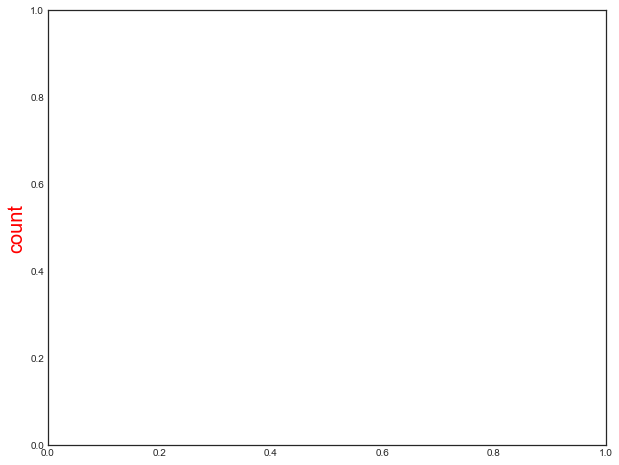

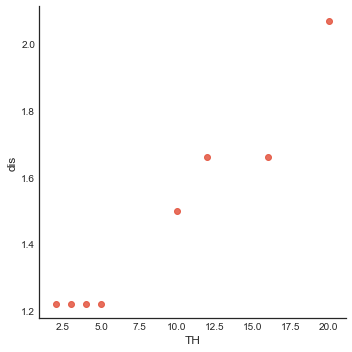

In [27]:
f, ax = plt.subplots(figsize = (10, 8))
sns.lmplot(x = 'TH', y= 'dis', data = t, fit_reg=False)
ax.set_ylabel('count', fontsize=20, color='r')
ax.set_xlabel(var+'(sotiert nach Anzahl der Auftrags)', fontsize=20, color='b')

In [164]:
top100 = dic1.top(10)

In [165]:
t_w = [i[0] for i in top100]
t_c = [i[1] for i in top100]

In [166]:
top100_b = [i.to_list() for i in dic2.get_words(t_w)]

In [167]:
t_w2 = [i[0] for i in top100_b]
t_c2 = [i[1] for i in top100_b]

In [168]:
#d = pd.DataFrame({'Teile-Nr': t_w, 'count_sk':t_c, 'count_nsk':t_c2})
d1 = pd.DataFrame({'Teile-Nr': t_w, 'count': t_c, 'is_sk': 'JA'})
d2 = pd.DataFrame({'Teile-Nr': t_w, 'count': t_c2, 'is_sk': 'Nein'})
d = pd.concat([d1,d2], axis=0)
d = d.drop([0], axis=0)

In [169]:
# get propotion
d['count'] = d['count']/d['count'].sum()

In [170]:
def draw_distribution(var):
    af = toAuftragTable(data1, var, 'Auftragsnummer')
    cv = af[var].value_counts()
    df_vc = pd.DataFrame({var:cv.index, 'count': cv.tolist()})
    tp = df_vc[['count']]
    f, ax = plt.subplots(figsize = (10, 8))
    tp.plot(ax=ax)
    ax.set_ylabel('count', fontsize=20, color='r')
    ax.set_xlabel(var+'(sotiert nach Anzahl der Auftrags)', fontsize=20, color='b')
    return df_vc

Text(0.5,0,'Teile-Nr')

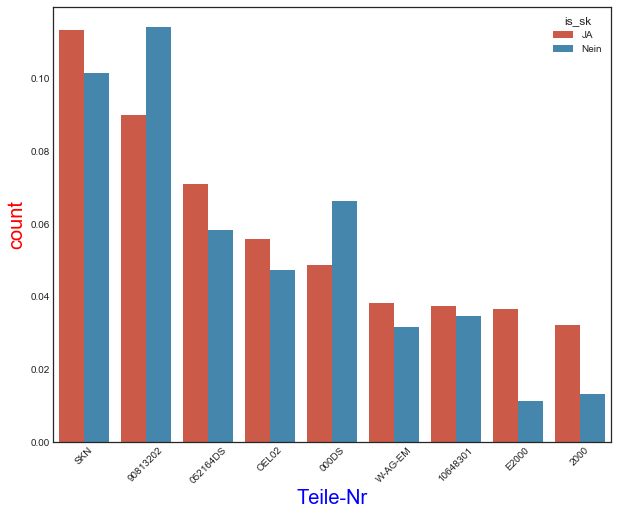

In [171]:
f, ax = plt.subplots(figsize = (10, 8))
sns.barplot(x = 'Teile-Nr', y= 'count', data=d, hue = 'is_sk')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel('count', fontsize=20, color='r')
ax.set_xlabel('Teile-Nr', fontsize=20, color='b')

Text(0.5,0,'am häufigsten gekauften Komponenten')

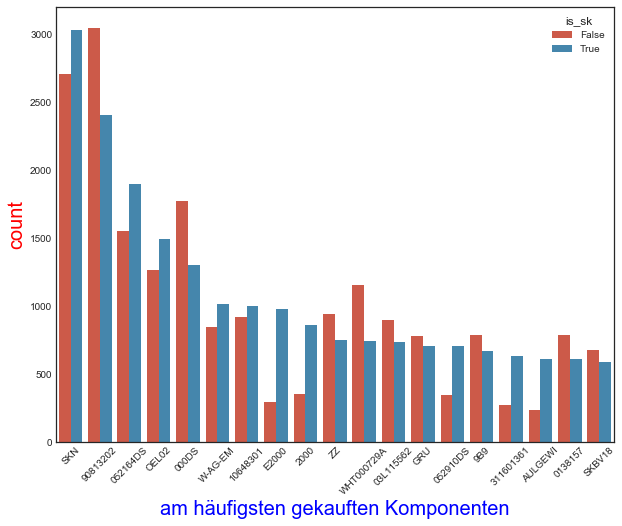

In [83]:
f, ax = plt.subplots(figsize = (10, 8))
sns.barplot(x = 'Teile-Nr', y= 'count', data=d, hue = 'is_sk')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel('count', fontsize=20, color='r')
ax.set_xlabel('am häufigsten gekauften Komponenten', fontsize=20, color='b')

In [69]:
d

,Teile-Nr,count,is_sk
1,SKN,3030,True
2,90813202,2403,True
3,052164DS,1899,True
4,OEL02,1492,True
5,000DS,1303,True
6,W-AG-EM,1017,True
7,10648301,997,True
8,E2000,979,True
9,2000,859,True
10,ZZ,752,True


## oftest gekaufte Komponenten

In [212]:
class FreDict:
    """
    统计单词和出现的频率
    文档中的每个字都会被记录进去，所以应该确认输入的文件内容，只含有目标列属性
    """
    def __init__(self, path, header = True, sep = ';', clean = False, recover = False, singular = False):
        """
        input:
            path: string
                the path of the file
            header: boolean
                weather the file contains header of not
            sep: string
                the sep of the file in each line
            clean: boolean
                remove the word with single buchstachben or not
            recover: boolean
                transform 'ae', 'oe', 'ue', 'ss' back to 'ä', 'ö', 'ü', 'ß' usw.
            singular: boolean
                weather turns the word to singular or not
        """
        self.dict_re = {'ae': 'ä', 'oe': 'ö', 'ue': 'ü', 'ß': 'ss', 'u.': 'und ', 'fzg': 'fahrzeug', ' f ': ' für '}
        self.words, self.dict_count = self._load_data(path, header, sep, clean, recover, singular) # list of Words
        self.ls_sorted = self._sort_dict(self.words) # list of list
        self.len = len(self.words)
    
    def get_word(self, w):
        if w in self.dict_count.keys():
            return self.dict_count[w]
        else:
            return Word('x', 0, 'NAW')
    
    def get_words(self, ws):
        out = []
        for w in ws:
            out.append(self.get_word(w))
        return out
    
    def get_best(self, s):
        """
        input:
            s string:
                list of words in form of string
        output:
            out string:
                the frequentest word
        """
        words = s.split(' ')
        words = [word.strip() for word in words]
        out = 'xxx'
        count = 0
        for word in words:
            tmp = self.get_word(word)
            if tmp.get_count() > count:
                out = tmp.get_word()
                count = tmp.get_count()
        return out
        
    def top(self, n = 10):
        # return list of list
        # get the top n item 
        if n == -1:
            return self.ls_sorted
        return self.ls_sorted[:n]
    
    def top_norm(self, n = 10):
        # get the top n norm
        out = []
        counter = 0
        for i in self.ls_sorted:
            if counter >= n and n != -1:
                break
            if i[2] == 'NN' or i[2] == 'NNP' or i[2] == 'NNS' or i[2] == 'NNPS':
                out.append(i)
            counter += 1
        return out
    
    def top_verb(self, n = 10):
        # get the top n verb
        out = []
        counter = 0
        for i in self.ls_sorted:
            if counter >= n and n != -1:
                break
            if i[2] == 'VB' or i[2] == 'VBZ' or i[2] == 'VBP' or i[2] == 'VBD' or i[2] == 'VBN' or i[2] == 'VBG':
                out.append(i)
            counter += 1
        return out
    
    def _load_data(self, path, header, sep, clean, recover, singular):
        """
        return list of words and count dictionary
        """
        dic = {}
        with open(path) as fi:
            counter = 0
            for li in fi:
                li = li.strip()
                if li[0] == '"':
                    li = li[1:]
                if li[-1] == '"':
                    li = li[:-1]
                if header and counter == 0:
                    # drop first line if header is true
                    counter += 1
                    continue
                li = li.strip()
                if recover:
                    # recover same express if necessary
                    for i, j in self.dict_re.items():
                        if i in li:
                            li = re.sub(i, j, li)
                #items = re.split('[;, ]', li)
                items = li.split(sep)
                for item in items:
                    if item not in dic.keys():
                        if clean and len(item) <= 1:
                            # remove the item with less than 2 ziffer
                            continue
                        else:
                            dic[item] = 1
                    else:
                        dic[item] += 1
                counter += 1
        # transform to Word
        words = []
        for i, j in dic.items():
            try:
                if singular:
                    i = singularize(i).lower()
                words.append(Word(i, j, parse(i).split('/')[1]))
                #words.append(Word(i, j, parse(conjugate(i)).split('/')[1]))
            except:
                words.append(Word(i, j, ''))
        # pack the dic
        dic = {i: Word(i, j, parse(i).split('/')[1]) for i, j in dic.items() if len(i) > 0 }
        # return 
        return words, dic
    
    def _sort_dict(self, words):
        # return list of words, sorted according to the count
        li_sorted = sorted(words, key = lambda x: x.get_count(), reverse = True) 
        # transform to list
        out = []
        for i in li_sorted:
            out.append(i.to_list())
        return out
    
class Word:
    """
    use @property to rewrite the class
    """
    def __init__(self, word = 'NN', count = 1, tag = 'NN'):
        self.word = word
        self.count = count
        self.tag = tag

    def to_list(self):
        out = [self.word, self.count, self.tag]
        return out
    
    def __str__(self):
        return self.word + " " + self.count + " " + self.tag

    def get_count(self):
        return self.count

    def get_tag(self):
        return self.tag

    def get_word(self):
        return self.word

    def set_count(self, c):
        self.count = c

    def set_tag(self, t):
        self.tag = t

    def set_word(self, w):
        self.word = w

In [213]:
df['Teile-Nr'].to_csv('/tmp/tmp.csv', sep = ';', index = False)
dic = FreDict('/tmp/tmp.csv', header = True, sep = ';', clean = True, recover = True, singular = False)
dic.top()

[['nan', 91408, 'NN'],
 ['N  90813202', 13322, 'NN'],
 ['B  000DS', 8948, 'NN'],
 ['G  052164DS', 8939, 'NN'],
 ['OEL02', 7451, 'NN'],
 ['WHT000729A', 5849, 'NNP'],
 ['000010006', 5248, 'CD'],
 ['W-AG-EM', 5107, 'NN'],
 ['03L115562', 4907, 'NN'],
 ['1K1819653B', 4479, 'NN']]

In [214]:
df_14['Teile-Nr'].to_csv('/tmp/tmp.csv', sep = ';', index = False)
dic = FreDict('/tmp/tmp.csv', header = True, sep = ';', clean = True, recover = True, singular = False)
a = dic.top()

In [215]:
print([b[0] for b in a])
print([b[1] for b in a])

['nan', 'N  90813202', 'B  000DS', 'G  052164DS', 'OEL02', '03L115562', '1K1819653B', 'N  10648301', '1100', '000010006']
[19654, 3173, 1959, 1934, 1648, 1336, 1275, 998, 952, 910]


In [216]:
df_15['Teile-Nr'].to_csv('/tmp/tmp.csv', sep = ';', index = False)
dic = FreDict('/tmp/tmp.csv', header = True, sep = ';', clean = True, recover = True, singular = False)
#dic.top()
a = dic.top()
print([b[0] for b in a])
print([b[1] for b in a])

['nan', 'N  90813202', 'G  052164DS', 'B  000DS', 'OEL02', '03L115562', '1K1819653B', 'N  10648301', 'WHT000729A', 'N  0138157']
[18240, 2993, 2264, 1937, 1598, 1350, 1228, 931, 931, 928]


In [217]:
df_16['Teile-Nr'].to_csv('/tmp/tmp.csv', sep = ';', index = False)
dic = FreDict('/tmp/tmp.csv', header = True, sep = ';', clean = True, recover = True, singular = False)
#dic.top()
a = dic.top()
print([b[0] for b in a])
print([b[1] for b in a])

['nan', 'N  90813202', 'G  052164DS', 'B  000DS', 'OEL02', 'WHT000729A', '000010006', 'W-AG-EM', '03L115562', '1K1819653B']
[20259, 2870, 2162, 1821, 1638, 1386, 1259, 1236, 1101, 1010]


In [237]:
df_17['Teile-Nr'].to_csv('/tmp/tmp.csv', sep = ';', index = False)
dic = FreDict('/tmp/tmp.csv', header = True, sep = ';', clean = True, recover = True, singular = False)
#dic.top()
a = dic.top(20)
print([b[0] for b in a])
print([b[1] for b in a])

['nan', 'N  90813202', '000010006', 'B  000DS', 'OEL02', 'WHT000729A', 'W-AG-EM', 'G  052164DS', '03N115562', 'N  10648301', 'G  052910DS', 'SKBV18', 'N  0138157', '03L115562', 'SKN  90813202', '1K1819653B', '2000', '5Q0819653', '1100', 'D  00950025']
[21383, 2731, 2006, 1937, 1638, 1615, 1610, 1560, 1116, 925, 886, 871, 827, 751, 719, 639, 605, 582, 539, 531]


In [223]:
df_tn = pd.DataFrame({
    'Teile-Nr': [
        'N  90813202', 'B  000DS', 'G  052164DS', 'OEL02', '03L115562',
        'N  90813202', 'G  052164DS', 'B  000DS', 'OEL02', '03L115562',
        'N  90813202', 'G  052164DS', 'B  000DS', 'OEL02', '03L115562',
        'N  90813202', 'B  000DS', 'OEL02', 'G  052164DS', '03L115562',
    ],
    'count': [
        3173, 1959, 1934, 1648, 1336,
        2993, 2264, 1937, 1598, 1350,
        2870, 2162, 1821, 1638, 1386,
        2731, 1937, 1638, 1560, 827,
    ],
    'year':[2014,2014,2014,2014,2014,
           2015,2015,2015,2015,2015,
           2016,2016,2016,2016,1236,
           2017,2017,2017,2017,2017]
})

In [209]:
# oftest gekauft komponent:'90813202', 'SKN', '000DS', '000010006'
df_tn = pd.DataFrame({
    'Teile-Nr': ['SCHRAUBE(N)', 'SCHRAUBE(SKN)', 'BREMSFLÜSSIG', 'SCHEIBENREINIGER', 'Shell 0W-30',
                'SCHRAUBE(N)', 'SCHRAUBE(SKN)', 'SCHEIBENREINIGER', 'BREMSFLÜSSIG', 'Shell 0W-30',
                 'SCHRAUBE(N)', 'SCHRAUBE(SKN)', 'SCHEIBENREINIGER', 'BREMSFLÜSSIG', 'Shell 0W-30',
                 'SCHRAUBE(SKN)', 'SCHRAUBE(N)', 'BREMSFLÜSSIG', 'SCHEIBENREINIGER', 'Shell 0W-30',
                ],
    'count': [3873, 3359, 1959, 1934, 1648,
             3757, 3471, 2264, 1937, 1598,
             3641, 3150, 2288, 1939, 1638,
             3715, 3485, 2326, 1753, 1638],
    'year':[2014,2014,2014,2014,2014,
           2015,2015,2015,2015,2015,
           2016,2016,2016,2016,2016,
           2017,2017,2017,2017,2017]
})

In [219]:
# oftest gekauft komponent:'90813202', 'SKN', '000DS', '000010006'
df_tn = pd.DataFrame({
    'Teile-Nr': ['SCHRAUBE(SKN)', 'BREMSFLÜSSIG', 'SCHEIBENREINIGER', 'Shell 0W-30',
                'SCHRAUBE(SKN)', 'SCHEIBENREINIGER', 'BREMSFLÜSSIG', 'Shell 0W-30',
                 'SCHRAUBE(SKN)', 'SCHEIBENREINIGER', 'BREMSFLÜSSIG', 'Shell 0W-30',
                 'SCHRAUBE(SKN)', 'BREMSFLÜSSIG', 'SCHEIBENREINIGER', 'Shell 0W-30',
                ],
    'count': [3359, 1959, 1934, 1648,
             3471, 2264, 1937, 1598,
             3150, 2288, 1939, 1638,
             3715, 2326, 1753, 1638],
    'year':[2014,2014,2014,2014,
           2015,2015,2015,2015,
           2016,2016,2016,2016,
           2017,2017,2017,2017]
})

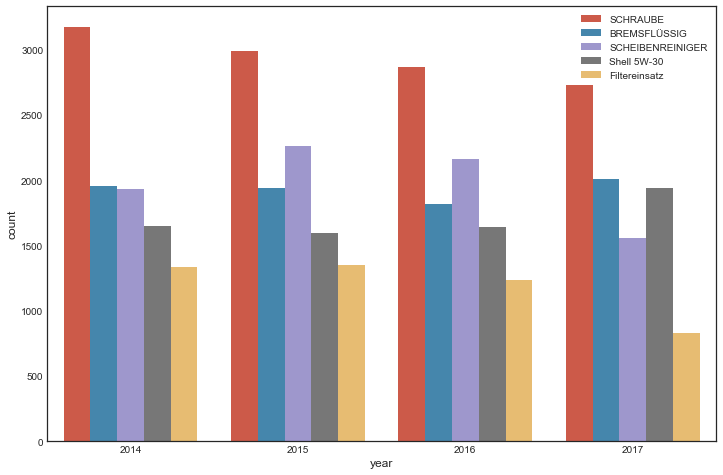

In [239]:
sns.barplot(x = 'year', y='count',hue='Teile-Nr', data=df_tn)
plt.legend(loc = "upper right")

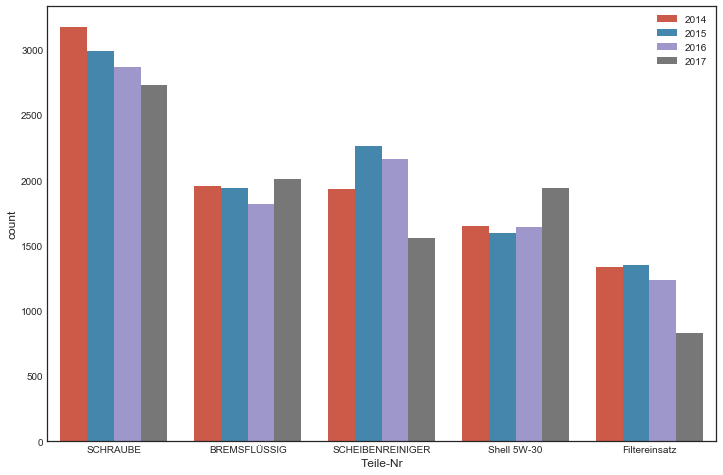

In [240]:
sns.barplot(x = 'Teile-Nr', y='count',hue='year', data=df_tn)
plt.legend(loc = "upper right")

In [197]:
train[train['Teile-Nr'] == 'N  90813202']['Beschreibung'].unique()

array(['SCHRAUBE', nan, 'Schraube', 'OELABLASSCHRAUBE', 'ÖLABLASSSCHRAUBE',
       'Ölablasschraube'], dtype=object)

In [193]:
train[train['Teile-Nr'] == 'SKN  90813202']['Beschreibung'].unique()

array(['SCHRAUBE'], dtype=object)

In [233]:
train[train['Teile-Nr'] == '000010006']['Beschreibung'].unique()

array(['HINWSCHILD', '^', nan], dtype=object)

In [238]:
df_tn = pd.DataFrame({
    'Teile-Nr': [
        'SCHRAUBE', 'BREMSFLÜSSIG', 'SCHEIBENREINIGER', 'Shell 5W-30', 'Filtereinsatz',
        'SCHRAUBE', 'SCHEIBENREINIGER', 'BREMSFLÜSSIG', 'Shell 5W-30', 'Filtereinsatz',
        'SCHRAUBE', 'SCHEIBENREINIGER', 'BREMSFLÜSSIG', 'Shell 5W-30', 'Filtereinsatz',
        'SCHRAUBE', 'BREMSFLÜSSIG', 'Shell 5W-30', 'SCHEIBENREINIGER', 'Filtereinsatz',
    ],
    'count': [
        3173, 1959, 1934, 1648, 1336,
        2993, 2264, 1937, 1598, 1350,
        2870, 2162, 1821, 1638, 1236,
        2731, 2006, 1937, 1560, 827,
    ],
    'year':[2014,2014,2014,2014,2014,
           2015,2015,2015,2015,2015,
           2016,2016,2016,2016,2016,
           2017,2017,2017,2017,2017]
})

In [ ]:
df_tn = pd.DataFrame({
    'Teile-Nr': [
        'N  90813202', 'B  000DS', 'G  052164DS', 'OEL02', '03L115562',
        'N  90813202', 'G  052164DS', 'B  000DS', 'OEL02', '03L115562',
        'N  90813202', 'G  052164DS', 'B  000DS', 'OEL02', '03L115562',
        'N  90813202', 'B  000DS', 'OEL02', 'G  052164DS', '03L115562',
    ],
    'count': [
        3173, 1959, 1934, 1648, 1336,
        2993, 2264, 1937, 1598, 1350,
        2870, 2162, 1821, 1638, 1386,
        2731, 1937, 1638, 1560, 827,
    ],
    'year':[2014,2014,2014,2014,2014,
           2015,2015,2015,2015,2015,
           2016,2016,2016,2016,1236,
           2017,2017,2017,2017,2017]
})

In [241]:
train['Teile-Nr'].value_counts()

N  90813202         15718
G  052164DS         10950
B  000DS            10494
OEL02                9120
W-AG-EM              7307
N  10648301          7169
WHT000729A           6941
000010006            6305
03L115562            5890
1K1819653B           5033
N  0138157           4414
SKBV18               4353
1100                 4151
SKN  90813202        3981
03N115562            3628
G  013DS             3432
2000                 3077
G  052910DS          3059
E2000                2701
ZVWLWASSER           2496
GEWI                 2473
D  00950025          2464
LMW030000Z0          2340
839601361            2321
311601361            2313
1K0825951            2288
7000                 2241
AULGEWI              2099
D  00940104          2011
W-SONST              1972
                    ...  
1J6945095BA             1
4L0821102               1
SK03C145299C            1
058903018 X             1
701010090H              1
5M0941109               1
SK5J6804875B            1
04L906054   